In [21]:
pip install nsetools


Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as  pd


In [23]:
# Load your dataset (ensure the file path is correct)
df1 = pd.read_csv('data\\NIFTY 50-01-01-2021-to-01-01-2022.csv')
df2 = pd.read_csv('data\\NIFTY 50-02-01-2022-to-01-01-2023.csv')
df3 = pd.read_csv('data\\NIFTY 50-02-01-2023-to-01-01-2024.csv')
df4 = pd.read_csv('data\\NIFTY 50-02-01-2024-to-17-11-2024.csv')

# Preview the df
merged_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Print the head and tail of the merged dfframe
print("Head of the merged dfframe:")
merged_df.head()




Head of the merged dfframe:


,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,01-JAN-2021,13996.10,14049.85,13991.35,14018.50,258090905.0,15873.75
1,04-JAN-2021,14104.35,14147.95,13953.75,14132.90,494999295.0,28705.09
2,05-JAN-2021,14075.15,14215.60,14048.15,14199.50,492475349.0,30872.87
3,06-JAN-2021,14240.95,14244.15,14039.90,14146.25,632323316.0,34615.55
4,07-JAN-2021,14253.75,14256.25,14123.10,14137.35,559173512.0,33446.47


In [24]:
print("\nTail of the merged dataframe:")
merged_df.tail()

df= merged_df.copy()


Tail of the merged dataframe:


Data preprocessing

In [25]:
print(df.isnull().sum())

# Optionally, fill missing values with forward filling or drop them
df.fillna(method='ffill', inplace=True)

Date               0
Open               0
High               0
Low                0
Close              0
Shares Traded      1
Turnover (₹ Cr)    1
dtype: int64


C:\Users\sadha\AppData\Local\Temp\ipykernel_29512\3642176079.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [26]:
df.columns

Index(['Date ', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (₹ Cr)'],
      dtype='object')

In [27]:


# Set 'Date' as the index
#df.set_index('Date ', inplace=True)

# Show the cleaned data
df.head()
data = df.copy()

In [28]:
data.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,01-JAN-2021,13996.10,14049.85,13991.35,14018.50,258090905.0,15873.75
1,04-JAN-2021,14104.35,14147.95,13953.75,14132.90,494999295.0,28705.09
2,05-JAN-2021,14075.15,14215.60,14048.15,14199.50,492475349.0,30872.87
3,06-JAN-2021,14240.95,14244.15,14039.90,14146.25,632323316.0,34615.55
4,07-JAN-2021,14253.75,14256.25,14123.10,14137.35,559173512.0,33446.47


In [29]:
data.tail()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
956,08-NOV-2024,24207.70,24276.15,24066.65,24148.20,298725122.0,27670.30
957,11-NOV-2024,24087.25,24336.80,24004.60,24141.30,273370562.0,26600.28
958,12-NOV-2024,24225.80,24242.00,23839.15,23883.45,255825829.0,26852.73
959,13-NOV-2024,23822.45,23873.60,23509.60,23559.05,304569316.0,27765.81
960,14-NOV-2024,23542.15,23675.90,23484.15,23532.70,257708474.0,24814.37


In [30]:
# Select only the 'Close' column for simplicity
import numpy as np
from sklearn.preprocessing import MinMaxScaler


close_prices = data['Close '].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Prepare the data for TCNN input
# Create a function to structure the data into sequences for TCNN
def create_sequences(data, sequence_length=8):
    sequences = []
    labels = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i, 0])  # Last 60 days as input
        labels.append(data[i, 0])  # The next day's price as label
    return np.array(sequences), np.array(labels)

# Create sequences for training
X, y = create_sequences(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for TCNN

# Split the data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.90)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [31]:
import tensorflow as tf

# Build the TCNN model with dilated convolutions
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1), dilation_rate=1),  # No dilation for first layer
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', dilation_rate=4),  # Dilated convolution in second layer
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression (next day's price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


c:\Sadhana\458\Module_7\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 7, 128)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,781 (155.39 KB)

 Trainable params: 39,781 (155.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0948 - val_loss: 0.0085
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0340
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 8.1305e-04
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 8.9963e-04
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9970e-04 - val_loss: 8.2479e-04


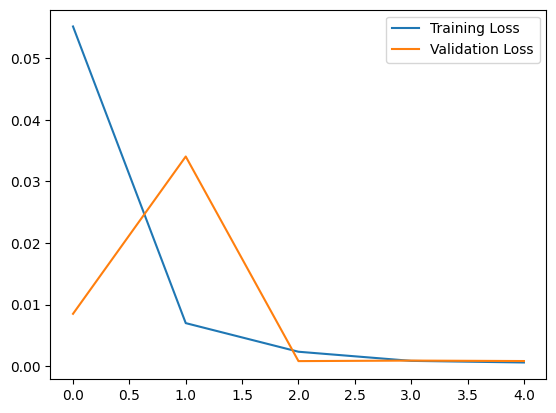

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


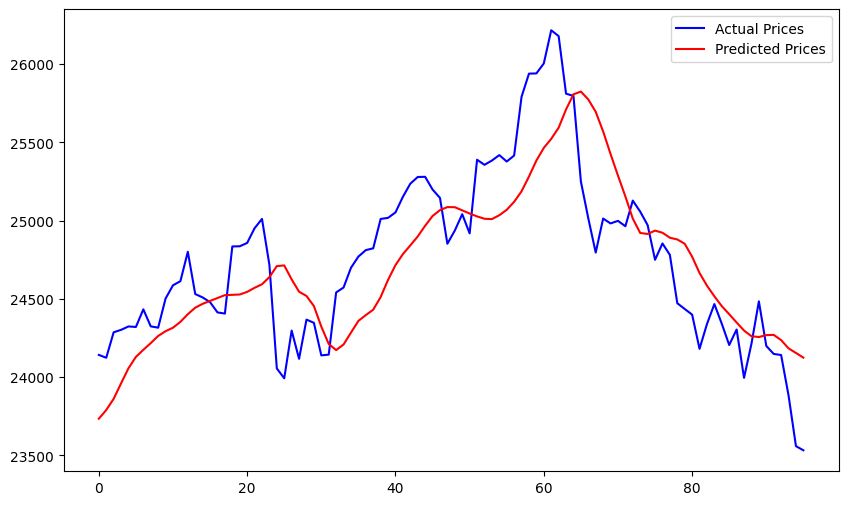

In [33]:
# Predict stock prices on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.legend()
plt.show()


In [ ]:
pip install keras_tuner

In [ ]:
import keras_tuner as kt
import tensorflow as tf

# Define the model as a function to be used with Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=256, step=32), 
            kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1), 
            activation='relu', 
            input_shape=(X_train.shape[1], 1),
            dilation_rate=hp.Int('dilation_rate', min_value=1, max_value=8, step=1)
        ),
        tf.keras.layers.Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=256, step=32), 
            kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1), 
            activation='relu', 
            dilation_rate=hp.Int('dilation_rate', min_value=1, max_value=8, step=1)
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        ),
        loss='mean_squared_error'
    )
    
    return model


In [ ]:


# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Use validation loss for optimization
    max_trials=20,  # Number of random hyperparameter combinations to try
    executions_per_trial=3,  # Number of models to train per combination
    directory='tuner_dir',
    project_name='tcnn_hyperparameter_tuning'
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")



In [ ]:
# Rebuild the model using the best hyperparameters
model = tuner.hypermodel.build(best_hyperparameters)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:

# Predict stock prices on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.legend()
plt.show()
